In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import nltk
import string
import re

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hafez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
sw = set(nltk.corpus.stopwords.words('english'))

def clean(text, stopwords):
    # remove tags like <tab>    
    text = re.sub(r'<[^<>]*>', ' ', text)  
    # split text on whitespace
    text_list = text.split()
    text_words = []
    
    punctuation = set(string.punctuation)
    
    # keep #tags and @mentions 
    ## punctuation.remove("#")
    ## punctuation.remove("@")
    
    for word in text_list:
        # remove punctuation marks at the beginning  
        # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]
        
        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]
        
        # a rule to eliminate most urls 
        if len(word) > 0 and "/" not in word:
            # eliminate stopwords 
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
        cleaner_text = " ".join(text_words)
    return cleaner_text

In [3]:
def ingest_and_clean_data():
    from pathlib import Path

    file_list_pos = [path for path in Path('imdb').rglob('*/pos/*.txt')]
    file_list_neg = [path for path in Path('imdb').rglob('*/neg/*.txt')]

    corpus_positive = [open(f, encoding="utf8").read() for f in file_list_pos]
    corpus_negative = [open(f, encoding="utf8").read() for f in file_list_neg]

    df = pd.DataFrame(corpus_positive, columns=['text'])
    df['sentiment'] = 'pos'

    df2 = pd.DataFrame(corpus_negative, columns=['text'])
    df2['sentiment'] = 'neg'

    df = df.append(df2)

    df['length'] = df.text.str.len()
    df = df[df.length >= 100]
    df.drop(['length'], axis=1, inplace=True)

    print(df.iloc[0])
    df['text'] = df['text'].apply(clean, stopwords=sw)
    print(df.iloc[0])

    df.to_pickle('reviews.pkl')

In [4]:
df = pd.read_pickle('reviews.pkl')



In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=123)

Trying Multinomial Naive Bayes

The train set accuracy is 0.910764305722289
The test set accuracy is 0.8692143524076297


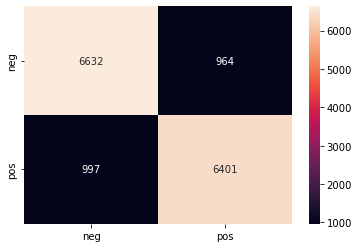

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pipe_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', MultinomialNB())])

pipe_nb.fit(X_train, y_train)

predicted_sentiment = pipe_nb.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = pipe_nb.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

In [20]:
len(pipe_nb.steps[0][1].get_feature_names())

86944

Trying Support Vector Machine

from sklearn.svm import SVC

pipe_svc = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', SVC())])

pipe_svc.fit(X_train, y_train)

predicted_sentiment = pipe_svc.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = pipe_svc.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Trying Random Forest

The train set accuracy is 1.0
The test set accuracy is 0.8604108309990663


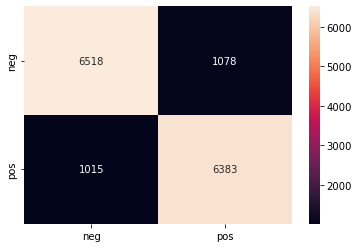

In [7]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', RandomForestClassifier())])

pipe_rf.fit(X_train, y_train)

predicted_sentiment = pipe_rf.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = pipe_rf.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Trying XGBoost

C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train set accuracy is 0.9264277139427199
The test set accuracy is 0.8558089902627718


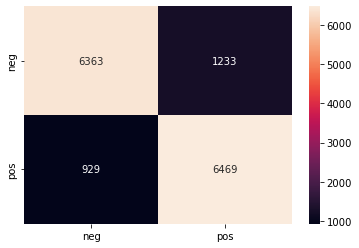

In [ ]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([('tfidf', TfidfVectorizer(stop_words="english")), ('clf', XGBClassifier(objective='multi:softmax', num_class=2))])

pipe_xgb.fit(X_train, y_train)

predicted_sentiment = pipe_xgb.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = pipe_xgb.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

Hyperparameter Tuning Naive Bayes

C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Hafez\anaconda3\envs\comp4448\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer =

The train set accuracy is 0.7004801920768308
The test set accuracy is 0.7034813925570228
Best Parameters: {'clf__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.1, 'tfidf__ngram_range': (1, 1)}


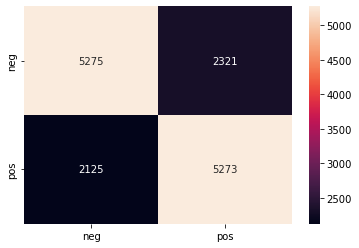

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {
    #'tfidf__max_features': (1000, 2000, 5000, 10000),
    'tfidf__min_df': (0.1, 0.25),
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1e-2, 1e-3)
}

grid_search = GridSearchCV(pipe_nb, parameters, cv=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")

Hyperparameter Tuning Random Forest

The train set accuracy is 1.0
The test set accuracy is 0.8726157129518474
Best Parameters: {'clf__n_estimators': 200, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}


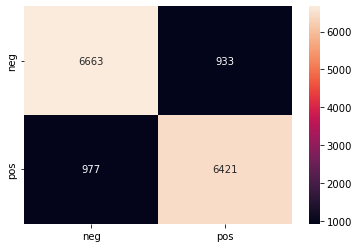

In [27]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_rf, parameters, cv=5, n_jobs=12)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")

Hyperparameter Tuning XGBoost

In [ ]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': (50, 100, 150, 200)
}

grid_search = GridSearchCV(pipe_xgb, parameters, cv=5)
grid_search.fit(X_train, y_train)

predicted_sentiment = grid_search.predict(X_test)


cm = confusion_matrix(y_test, predicted_sentiment)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])


predicted_sentiment_train = grid_search.predict(X_train)

print(f"The train set accuracy is {accuracy_score(y_train, predicted_sentiment_train)}")
print(f"The test set accuracy is {accuracy_score(y_test, predicted_sentiment)}")

print(f"Best Parameters: {grid_search.best_params_}")